# Gradient-based word deletion

I trained a model to "reidentify" individuals from information about them. Specifically, this model tries to read the beginning of a Wikipedia page and predict (given the infoboxes of many people's Wikipedia page) which person the page is about. Now I'm going to try and fool this "reidentifier" model, and see how many words I have to delete in order to fool the reidentifier a certain percentage of the time.

## 1. Load the model and make a prediction

In [1]:
import sys
sys.path.append('/home/jxm3/research/deidentification/unsupervised-deidentification')

In [60]:
from model import DocumentProfileMatchingTransformer

checkpoint_path = "/home/jxm3/research/deidentification/unsupervised-deidentification/saves/deid-wikibio_deid_exp/okpvvffw_46/checkpoints/epoch=7-step=1823.ckpt"
model = DocumentProfileMatchingTransformer.load_from_checkpoint(
    checkpoint_path
    dataset_name='wiki_bio',
    model_name_or_path='distilbert-base-uncased',
    num_workers=1,
    loss_fn='exact',
    num_neighbors=2048,
    base_folder="/home/jxm3/research/deidentification/unsupervised-deidentification",
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initialized DocumentProfileMatchingTransformer with learning_rate = 0.0002


In [3]:
from dataloader import WikipediaDataModule
import os

num_cpus = os.cpu_count()

dm = WikipediaDataModule(
    model_name_or_path='distilbert-base-uncased',
    dataset_name='wiki_bio',
    num_workers=min(8, num_cpus),
    train_batch_size=64,
    eval_batch_size=64,
    max_seq_length=64,
    redaction_strategy="",
    base_folder="/home/jxm3/research/deidentification/unsupervised-deidentification",
)
dm.setup("fit")

Initializing WikipediaDataModule with num_workers = 8


Using custom data configuration default
Reusing dataset wiki_bio (/home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da)
Using custom data configuration default
Reusing dataset wiki_bio (/home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da)
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-5535f82839d9fec4.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-5b1c3941089b7f1b.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-8a9b289bc8e70b72.arrow
Loading cached processed dataset at 

  0%|          | 0/15 [00:00<?, ?ba/s]

## 2. Define attack in TextAttack 

In [4]:
import textattack

### (a) Greedy word search + replace with `[MASK]`

In [5]:
search_method = textattack.search_methods.GreedyWordSwapWIR()

class WordSwapSingleWord(textattack.transformations.word_swap.WordSwap):
    """Takes a sentence and transforms it by replacing with a single fixed word.
    """
    single_word: str
    def __init__(self, single_word: str = "?", **kwargs):
        super().__init__(**kwargs)
        self.single_word = single_word

    def _get_replacement_words(self, _word: str):
        return [self.single_word]

In [6]:
transformation = WordSwapSingleWord(single_word='[MASK]')
transformation(textattack.shared.AttackedText("Hello my name is Jack"))

[<AttackedText "[MASK] my name is Jack">,
 <AttackedText "Hello [MASK] name is Jack">,
 <AttackedText "Hello my [MASK] is Jack">,
 <AttackedText "Hello my name [MASK] Jack">,
 <AttackedText "Hello my name is [MASK]">]

### (b) "Attack success" as fullfilment of the metric

In [89]:
from typing import List
import torch

class ChangeClassificationToBelowTopKClasses(textattack.goal_functions.ClassificationGoalFunction):
    k: int
    def __init__(self, *args, k: int = 1, **kwargs):
        self.k = k
        super().__init__(*args, **kwargs)

    def _is_goal_complete(self, model_output, _):
        original_class_score = model_output[self.ground_truth_output]
        num_better_classes = (model_output > original_class_score).sum()
        return num_better_classes >= self.k

    def _get_score(self, model_output, _):
        return 1 - model_output[self.ground_truth_output]
    
    
    """have to reimplement the following method to change the precision on the sum-to-one condition."""
    def _process_model_outputs(self, inputs, scores):
        """Processes and validates a list of model outputs.
        This is a task-dependent operation. For example, classification
        outputs need to have a softmax applied.
        """
        # Automatically cast a list or ndarray of predictions to a tensor.
        if isinstance(scores, list):
            scores = torch.tensor(scores)

        # Ensure the returned value is now a tensor.
        if not isinstance(scores, torch.Tensor):
            raise TypeError(
                "Must have list, np.ndarray, or torch.Tensor of "
                f"scores. Got type {type(scores)}"
            )

        # Validation check on model score dimensions
        if scores.ndim == 1:
            # Unsqueeze prediction, if it's been squeezed by the model.
            if len(inputs) == 1:
                scores = scores.unsqueeze(dim=0)
            else:
                raise ValueError(
                    f"Model return score of shape {scores.shape} for {len(inputs)} inputs."
                )
        elif scores.ndim != 2:
            # If model somehow returns too may dimensions, throw an error.
            raise ValueError(
                f"Model return score of shape {scores.shape} for {len(inputs)} inputs."
            )
        elif scores.shape[0] != len(inputs):
            # If model returns an incorrect number of scores, throw an error.
            raise ValueError(
                f"Model return score of shape {scores.shape} for {len(inputs)} inputs."
            )
        elif not ((scores.sum(dim=1) - 1).abs() < 1e-4).all():
            # Values in each row should sum up to 1. The model should return a
            # set of numbers corresponding to probabilities, which should add
            # up to 1. Since they are `torch.float` values, allow a small
            # error in the summation.
            scores = torch.nn.functional.softmax(scores, dim=1)
            if not ((scores.sum(dim=1) - 1).abs() < 1e-4).all():
                raise ValueError("Model scores do not add up to 1.")
        return scores.cpu()


## (c) Model wrapper that computes similarities of input documents with validation profiles

In [69]:
import transformers

class MyModelWrapper(textattack.models.wrappers.ModelWrapper):
    model: DocumentProfileMatchingTransformer
    tokenizer: transformers.PreTrainedTokenizer
    profile_embeddings: torch.Tensor
    max_seq_length: int
    
    def __init__(self, model: DocumentProfileMatchingTransformer, tokenizer: transformers.PreTrainedTokenizer, max_seq_length: int = 64):
        self.model = model
        self.tokenizer = tokenizer
        self.profile_embeddings = torch.tensor(model.val_embeddings)
        self.max_seq_length = max_seq_length
                 
    def to(self, device):
        self.model.to(device)
        self.profile_embeddings.to(device)
        return self # so semantics `model = MyModelWrapper().to('cuda')` works properly

    def __call__(self, text_input_list, batch_size=32):
        model_device = next(self.model.parameters()).device
        tokenized_ids = self.tokenizer.batch_encode_plus(
            text_input_list,
            max_length=self.max_seq_length,
            padding=True,
            truncation=True
        )
        try:
            tokenized_ids = {k: torch.tensor(v).to(model_device) for k,v in tokenized_ids.items()}
        except:
            breakpoint()
        
        # TODO: implement batch size if we start running out of memory here.
        with torch.no_grad():
            document_embeddings = self.model.document_model(**tokenized_ids)
            document_embeddings = document_embeddings['last_hidden_state'][:, 0, :] # (batch, document_emb_dim)
            document_embeddings = self.model.lower_dim_embed(document_embeddings) # (batch, emb_dim)

        document_to_profile_probs = torch.nn.functional.softmax(
            document_embeddings @ self.profile_embeddings.T.to(model_device), dim=-1)
        assert document_to_profile_probs.shape == (len(text_input_list), len(self.profile_embeddings))
        return document_to_profile_probs
            

## (d) Dataset that loads Wikipedia documents with names as labels

In [9]:
next(iter(dm.val_dataloader()))

{'document_input_ids': tensor([[  101,  4831,  2745,  ..., 10722, 26896,   102],
         [  101, 17504, 12022,  ...,     0,     0,     0],
         [  101,  7929,  2319,  ...,     0,     0,     0],
         ...,
         [  101,  9033,  2860,  ..., 12681,  5283,   102],
         [  101,  7332, 27319,  ...,   102,     0,     0],
         [  101,  3958, 11463,  ...,     0,     0,     0]]),
 'document_attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'document_redact_ner_input_ids': tensor([[  101,  4831,   103,  ...,  1010,  3140,   102],
         [  101, 17504, 12022,  ...,     0,     0,     0],
         [  101,   103,   103,  ...,     0,     0,     0],
         ...,
         [  101,  9033,  2860,  ..., 15810,  8840,   102],
         [  101,   103,   103,  ...,   102,     0,     0],
         [  1

In [20]:
from typing import Tuple

from collections import OrderedDict

import datasets

class WikiDataset(textattack.datasets.Dataset):
    dataset: datasets.Dataset
    
    def __init__(self, dm: WikipediaDataModule):
        self.shuffled = True
        self.dataset = dm.val_dataset
        self.label_names = list(dm.val_dataset['name'])
    
    def __len__(self) -> int:
        return len(self.dataset)
    
    def __getitem__(self, i: int) -> Tuple[OrderedDict, int]:
        input_dict = OrderedDict([
            ('document', self.dataset['document'][i])
        ])
        return input_dict, self.dataset['text_key_id'][i].item()
        

## 3. Run attack once

In [107]:
from textattack.loggers import CSVLogger
from textattack.shared import AttackedText

import pandas as pd
class CustomCSVLogger(CSVLogger):
    """Logs attack results to a CSV."""

    def log_attack_result(self, result: textattack.goal_function_results.ClassificationGoalFunctionResult):
        original_text, perturbed_text = result.diff_color(self.color_method)
        original_text = original_text.replace("\n", AttackedText.SPLIT_TOKEN)
        perturbed_text = perturbed_text.replace("\n", AttackedText.SPLIT_TOKEN)
        result_type = result.__class__.__name__.replace("AttackResult", "")
        row = {
            "original_person": result.original_result._processed_output[0],
            "original_text": original_text,
            "perturbed_person": result.perturbed_result._processed_output[0],
            "perturbed_text": perturbed_text,
            "original_score": result.original_result.score,
            "perturbed_score": result.perturbed_result.score,
            "original_output": result.original_result.output,
            "perturbed_output": result.perturbed_result.output,
            "ground_truth_output": result.original_result.ground_truth_output,
            "num_queries": result.num_queries,
            "result_type": result_type,
        }
        self.df = pd.concat([self.df, pd.DataFrame([row])], ignore_index=True)
        self._flushed = False

In [90]:
from textattack import Attack
from textattack.constraints.pre_transformation import RepeatModification

model_wrapper = MyModelWrapper(model, dm.tokenizer)
model_wrapper.to('cuda')

goal_function = ChangeClassificationToBelowTopKClasses(model_wrapper, k=10)
constraints = [RepeatModification()]
transformation = WordSwapSingleWord(single_word='[MASK]')
search_method = textattack.search_methods.GreedyWordSwapWIR()

attack = Attack(
    goal_function, constraints, transformation, search_method
)

textattack: No entry found for goal function <class '__main__.ChangeClassificationToBelowTopKClasses'>.
textattack: Unknown if model of class <class 'model.DocumentProfileMatchingTransformer'> compatible with goal function <class '__main__.ChangeClassificationToBelowTopKClasses'>.


In [108]:
# 
#  Initialize attack
# 
from tqdm import tqdm # tqdm provides us a nice progress bar.
from textattack.attack_results import SuccessfulAttackResult
from textattack import Attacker
from textattack import AttackArgs

attack_args = AttackArgs(num_examples=25, disable_stdout=True)
dataset = WikiDataset(dm)

attacker = Attacker(attack, dataset, attack_args)

results_iterable = attacker.attack_dataset()

logger = CustomCSVLogger(color_method='html')

# 
# Run attack
# 
from tqdm import tqdm
for result in results_iterable:
    tqdm._instances.clear() # Doesn't fix the progress bar :-(
    logger.log_attack_result(result)

from IPython.display import display, HTML

display(HTML(logger.df.to_html(escape=False)))

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  ChangeClassificationToBelowTopKClasses
  (transformation):  WordSwapSingleWord
  (constraints): 
    (0): RepeatModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 20 / 3 / 0 / 23:  92%|█████████▏| 23/25 [00:16<00:01,  1.39it/s]textattack: CSVLogger exiting without calling flush().
  0%|          | 0/100 [17:32<?, ?it/s]
[Succeeded / Failed / Skipped / Total] 20 / 5 / 0 / 25: 100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 20     |
| Number of failed attacks:     | 5      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 15.26% |
| Average num. words per input: | 92.8   |
| Avg num queries:              | 136.52 |
+-------------------------------+--------+


textattack: Logging to CSV at path results.csv


,original_person,original_text,perturbed_person,perturbed_text,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,result_type
0,Michael iii of alexandria,"pope michael iii of alexandria -lrb- also known as khail iii -rrb- was the coptic pope of alexandria and patriarch of the see of st. mark -lrb- 880 -- 907 -rrb- .in 882 , the governor of egypt , ahmad ibn tulun , forced khail to pay heavy contributions , forcing him to sell a church and some attached properties to the local jewish community .this building was at one time believed to have later become the site of the cairo geniza .",'' ` bahauddeen muhammed nadwi '' ',"pope michael [MASK] of [MASK] -lrb- also known as [MASK] [MASK] -rrb- was the coptic pope of [MASK] and patriarch of the see of st. [MASK] -lrb- 880 -- 907 -rrb- .in 882 , the governor of egypt , ahmad ibn tulun , forced khail to pay [MASK] contributions , [MASK] him to sell a church and some attached properties to the local jewish community .this building was at one [MASK] believed to have later become the site of the cairo geniza .",0.406447,0.985584,0,6514,0,95,Successful
1,Hui jun,hui jun is a male former table tennis player from china .,Shin kyeong-nim,[MASK] [MASK] [MASK] a male [MASK] [MASK] [MASK] [MASK] from [MASK] .,0.000000,0.998420,1,6036,1,21,Successful
2,Kittisak jaihan,okan Öztürk -lrb- born 30 november 1977 -rrb- is a turkish professional footballer .he currently plays as a striker for yeni malatyaspor .,Kittisak jaihan,[MASK] Öztürk -lrb- born 30 november 1977 -rrb- is a turkish professional footballer .he currently plays as a striker for yeni malatyaspor .,0.899324,0.992933,13715,13715,2,24,Successful
3,Marie stephan,"marie stephan , -lrb- born march 14 , 1996 -rrb- is a professional squash player who represents france .she reached a career-high world ranking of world no. 101 in july 2015 .",Martin ferrero,"[MASK] [MASK] , -lrb- born march 14 , 1996 -rrb- is a professional [MASK] player who [MASK] [MASK] .she [MASK] [MASK] career-high world ranking [MASK] world [MASK]. [MASK] in july 2015 .",0.275657,0.987234,3,13841,3,48,Successful
4,Leonard l. martino,leonard l. martino is a former democratic member of the pennsylvania house of representatives .he was born in butler to michael and angela pitullio martino .,Cary kennedy,[MASK] [MASK]. martino is a former democratic member of the [MASK] house of [MASK] .he was born in [MASK] to michael and angela pitullio martino .,0.732253,0.984586,4,9767,4,31,Successful
5,Salome jens,"salome jens -lrb- born may 8 , 1935 -rrb- is an american stage , film and television actress .she is perhaps best known for portraying the female changeling on '' '' .",Martin ferrero,"[MASK] [MASK] -lrb- born may 8 , 1935 -rrb- is an american stage , film and television actress .she is perhaps best known for portraying the female [MASK] on '' '' .",0.024180,0.974487,5,13841,5,31,Successful
6,Carl crawford,"carl demonte crawford -lrb- born august 5 , 1981 -rrb- , nicknamed `` the perfect storm '' , is an american professional baseball left fielder with the los angeles dodgers of major league baseball -lrb- mlb -rrb- .he bats and throws left-handed .crawford was drafted by the tampa bay devil rays in the second round -lrb- 52nd overall -rrb- of the 1999 major league baseball draft .he made his major league debut in 2002 .crawford has more triples -lrb- 121 -rrb- than any other active baseball player .",Walt smallwood,"carl [MASK] [MASK] -lrb- born august 5 , 1981 -rrb- , nicknamed `` the perfect storm '' , is an american professional baseball left fielder with the los angeles [MASK] of major league baseball -lrb- mlb -rrb- .he bats and throws left-handed .[MASK] [MASK] drafted by the tampa bay devil rays in the second round -lrb- 52nd overall -rrb- of the 1999 major league baseball draft .he made his major league [MASK] in 2002 .crawford has more triples -lrb- 121 -rrb- than any other active baseball player .",0.190520,0.996724,6,1146

In [57]:
dm.val_dataset[7243]

{'document_input_ids': tensor([  101, 13326, 14684,  9397,  1011,  1048, 15185,  1011,  2141,  2233,
          2459,  1010,  3106,  1011, 25269,  2497,  1011,  2003,  2019,  2137,
          2658,  3256,  3873,  2447,  2040,  2003,  2747,  2652,  2007,  1996,
         29142, 13774,  2545,  1997,  1996, 14925,  7317,  1012,  3188,  2000,
          3810,  2658,  1010, 14684,  9397,  2209,  2176,  2086,  1997,  2267,
          3873,  2012, 23202,  2110,  2118,  2007,  1996, 23202,  2110, 15120,
          2273,  1005,  1055,   102]),
 'document_attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'document_redact_ner_input_ids': tensor([  101, 13326, 14684,  9397,  1011,  1048, 15185,  1011,  2141,   103,
           103,   103,   103,  1011, 25269,  2497,  1011,  2003,  2019,   103,
           103,   103,  38

## 4. Run attack in loop and make plot for multiple values of $\epsilon$

In [ ]:
# 
#  Initialize attack
# 
from tqdm import tqdm # tqdm provides us a nice progress bar.
from textattack.attack_results import SuccessfulAttackResult
from textattack import Attacker
from textattack import AttackArgs

dataset = WikiDataset(dm)

meta_results = []
for k in range(1, 50):
    print(f'***Attacking with k={k}***')
    dataset = WikiDataset(dm)
    goal_function = ChangeClassificationToBelowTopKClasses(model_wrapper, k=k)
    attack = Attack(
        goal_function, constraints, transformation, search_method
    )
    attack_args = AttackArgs(num_examples=1000, disable_stdout=True)
    attacker = Attacker(attack, dataset, attack_args)

    results_iterable = attacker.attack_dataset()

    logger = CustomCSVLogger(color_method='html')

    for result in results_iterable:
        logger.log_attack_result(result)
    
    meta_results.append( (k,  logger.df['result_type'].value_counts().get('Successful', 0),  logger.df['result_type'].value_counts().get('Failed', 0) ) )

import pandas as pd
meta_df = pd.DataFrame(meta_results, columns=['k', 'Successes', 'Failures']).head()

textattack: No entry found for goal function <class '__main__.ChangeClassificationToBelowTopKClasses'>.
textattack: Unknown if model of class <class 'model.DocumentProfileMatchingTransformer'> compatible with goal function <class '__main__.ChangeClassificationToBelowTopKClasses'>.


***Attacking with k=1***
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  ChangeClassificationToBelowTopKClasses
  (transformation):  WordSwapSingleWord
  (constraints): 
    (0): RepeatModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 55 / 13 / 8 / 76:   8%|▊         | 76/1000 [00:44<09:02,  1.70it/s]

<AxesSubplot:xlabel='k'>

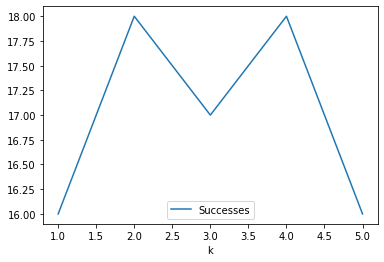

In [113]:
meta_df.plot(x='k', y='Successes')